In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
DIRECTORY = 'drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_05/'

In [ ]:
!cp drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_05/train_utils.py train_utils.py

## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Иванов Максим Юрьевич

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [ ]:
from train_utils import train, get_loaders

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [ ]:
# Dataloader
to_numpy = lambda x: x.numpy()

base_train_loader, base_test_loader = get_loaders(download=True, batch_size=128)
train_loader, test_loader = base_train_loader, base_test_loader

In [ ]:
images_train, labels_train = next(iter(train_loader))

In [ ]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

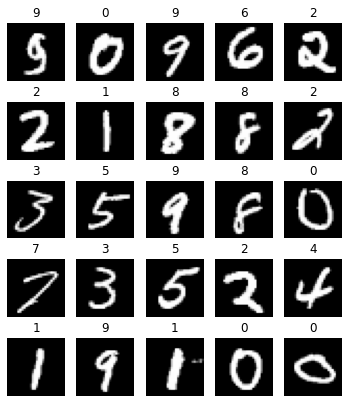

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [ ]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

def Linear(in_n, out_n):
    layer = nn.Linear(in_n, out_n)

    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    return layer

def normal_init(size_input, size_output):
    return 0.1

def xavier_init(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def he_init(size_input, size_output):
    d = 2 / size_output
    return np.sqrt(d)

def make_network(init_func=normal_init, sizes=None, activation=nn.Tanh):
    sizes = sizes or [28 * 28] + [500] * 10 + [10]
    layers = []

    for size_input, size_output in zip(sizes, sizes[1:]):
        layer = Linear(size_input, size_output)
        init_layer(layer, 0.0, init_func(size_input, size_output))
        layers.append(layer)
        layers.append(activation())

    del layers[-1]

    return nn.Sequential(*layers)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [ ]:
def test_network(network, n_objects=100):
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()

    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

    loss = loss_fn(activations, y)
    loss.backward()

In [ ]:
network = make_network()
test_network(network)

forward 1.0211641788482666
forward 0.8487091064453125
forward 0.7875081300735474
forward 0.7670426964759827
forward 0.7654088735580444
forward 0.761204183101654
forward 0.763034462928772
forward 0.7642739415168762
forward 0.7670193314552307
forward 0.7648082971572876
forward 0.7636939883232117
backward 0.028284268453717232
backward 0.014188211411237717
backward 0.013676022179424763
backward 0.014000408351421356
backward 0.013889040797948837
backward 0.014434305019676685
backward 0.016731439158320427
backward 0.01838306337594986
backward 0.021894771605730057
backward 0.024708878248929977
backward 0.024678388610482216


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
network = make_network(init_func=lambda x, y: 1)
test_network(network)

forward 1.0211641788482666
forward 0.9851695895195007
forward 0.9817195534706116
forward 0.9818819165229797
forward 0.9821841716766357
forward 0.9823020100593567
forward 0.9815135598182678
forward 0.9814233183860779
forward 0.9820383787155151
forward 0.9818907380104065
forward 0.9814373254776001
backward 0.028284268453717232
backward 0.019427435472607613
backward 0.05710693448781967
backward 0.18625815212726593
backward 0.6647374629974365
backward 2.439703941345215
backward 8.10354995727539
backward 31.541170120239258
backward 108.31444549560547
backward 369.6286926269531
backward 1127.6065673828125


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [ ]:
network = make_network(init_func=xavier_init)
test_network(network)

forward 1.0211641788482666
forward 0.6584680676460266
forward 0.5001600980758667
forward 0.4159751534461975
forward 0.3620155453681946
forward 0.3210104703903198
forward 0.2915462255477905
forward 0.2721172273159027
forward 0.25626784563064575
forward 0.2422679215669632
forward 0.2251480519771576
backward 0.028284268453717232
backward 0.019297821447253227
backward 0.017372606322169304
backward 0.01579897478222847
backward 0.014627688564360142
backward 0.013805043883621693
backward 0.012439298443496227
backward 0.011363736353814602
backward 0.009695868007838726
backward 0.007471595425158739
backward 0.0045698257163167


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
network = make_network(init_func=he_init)
test_network(network)

forward 1.0211641788482666
forward 0.7736395597457886
forward 0.6501429080963135
forward 0.6056609749794006
forward 0.5896925926208496
forward 0.5777134895324707
forward 0.5705564022064209
forward 0.5666822791099548
forward 0.5617697238922119
forward 0.5550645589828491
forward 0.5521068572998047
backward 0.028284268453717232
backward 0.09819426387548447
backward 0.09961643815040588
backward 0.10395863652229309
backward 0.09975212812423706
backward 0.09854670614004135
backward 0.09698481857776642
backward 0.0945982038974762
backward 0.08535703271627426
backward 0.0691162571310997
backward 0.04311611130833626


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<i> 1.4 Сделайте выводы по первой части </i>

Дисперсия данных лучше сохраняется при He

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [ ]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):   
        mask = torch.zeros_like(self.linear.weight) + self.p 
        if self.training:
            mask.bernoulli_()

        mask = mask.data # mask = mask.detach()
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [ ]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [ ]:
def make_layers(mode='none', sizes=None):
    sizes = sizes or [196, 128, 128, 10]
    layers = []

    for size_input, size_output in zip(sizes, sizes[1:]):
        if mode == 'none' or mode == 'dropout' or mode == 'batch_norm' or mode == 'layer_norm':
            layers.append(nn.Linear(size_input, size_output))
            if mode == 'dropout':
                layers.append(nn.Dropout(0.05))
            elif mode == 'batch_norm':
                layers.append(nn.BatchNorm1d(size_output))
            elif mode == 'layer_norm':
                layers.append(LayerNormalization(size_output))
        elif mode == 'dropconnect':
            layers.append(DropConnect(size_input, size_output, 0.8))
            # TODO: Сюда никогда не заходило, исправил, нужно перезапустить

        layers.append(nn.ReLU())

    del layers[-1]

    return nn.Sequential(*layers)

Epoch 9... (Train/Test) NLL: 0.060/0.066	Accuracy: 0.980/0.979


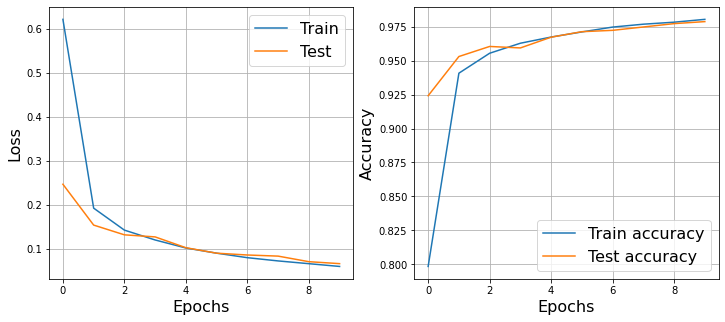

CPU times: user 1min 33s, sys: 716 ms, total: 1min 34s
Wall time: 1min 34s


In [ ]:
%%time

network = TestNetwork(make_layers())

train(network, train_loader, test_loader, device='cuda')

Epoch 9... (Train/Test) NLL: 0.144/0.207	Accuracy: 0.956/0.973


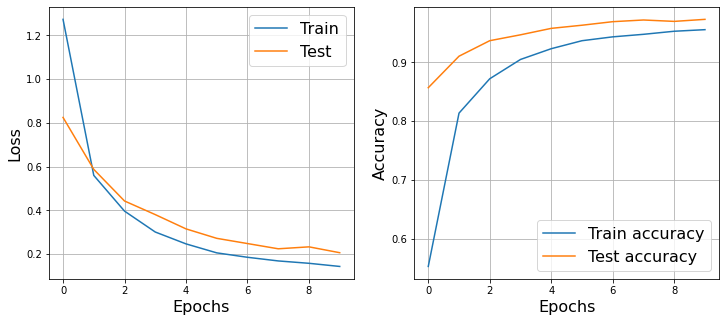

CPU times: user 1min 38s, sys: 693 ms, total: 1min 39s
Wall time: 1min 39s


In [ ]:
%%time

network = TestNetwork(make_layers('dropconnect'))

train(network, train_loader, test_loader, device='cuda')

Epoch 9... (Train/Test) NLL: 0.070/0.066	Accuracy: 0.974/0.980


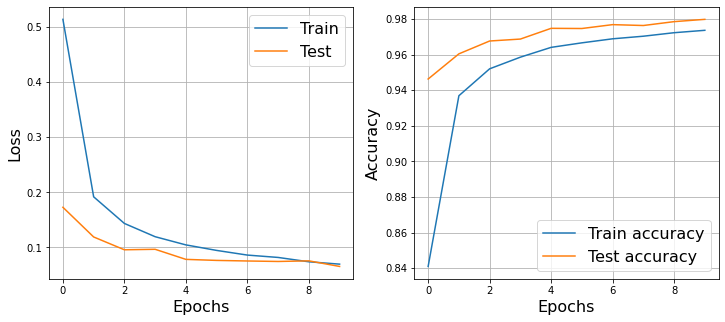

CPU times: user 1min 38s, sys: 670 ms, total: 1min 39s
Wall time: 1min 39s


In [ ]:
%%time

network = TestNetwork(make_layers('dropout'))

train(network, train_loader, test_loader, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Сеть с dropout работает лучше, чем с Dropconnect, и при этом нет переобучения, как в случае без dropout и dropconnect

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [ ]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, n_features, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(n_features))
        self.beta = nn.Parameter(torch.zeros(n_features))
        self.eps = eps

    def forward(self, x):
        output = self.gamma * (x - x.mean(-1, keepdim=True)) / (x.std(-1, keepdim=True) + self.eps) + self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.031/0.043	Accuracy: 0.993/0.988


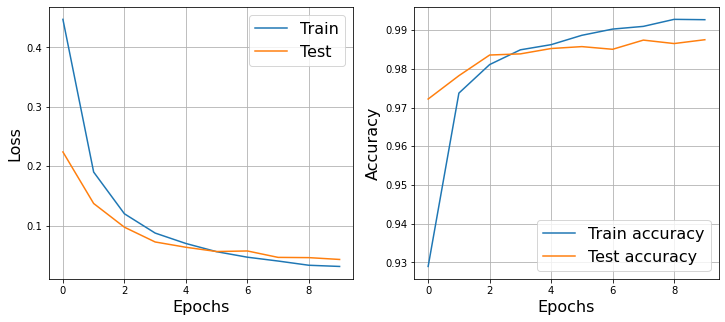

CPU times: user 1min 38s, sys: 670 ms, total: 1min 38s
Wall time: 1min 38s


In [ ]:
%%time

network = TestNetwork(make_layers('batch_norm'))
train(network, train_loader, test_loader, device='cuda')

Epoch 9... (Train/Test) NLL: 0.038/0.072	Accuracy: 0.989/0.981


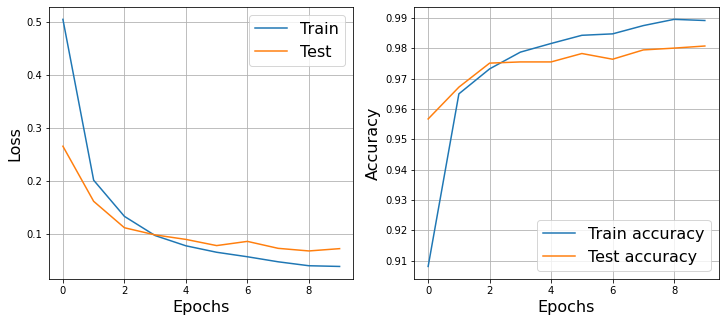

CPU times: user 1min 41s, sys: 702 ms, total: 1min 42s
Wall time: 1min 42s


In [ ]:
%%time

network = TestNetwork(make_layers('layer_norm'))
train(network, train_loader, test_loader, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

Batch нормализация показала лучший результат на тесте и на трейне

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: